In [164]:
import model
import yfinance as yf
import tensorflow as tf
import numpy as np
from keras.optimizers import SGD, RMSprop, Adam
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [146]:
import numpy as np
import math

def pre_process(ticker_data,Moving_window):
    #Calculate and insert Average price along each interval
    ticker_data_close = ticker_data['Close'].to_numpy()
    ticker_data_open = ticker_data['Open'].to_numpy()
    ticker_data_average = (ticker_data_close + ticker_data_open)/2
    ticker_data.insert(1, 'Average', ticker_data_average)
    
    #Calculate RSI
    change = ticker_data['Average'].diff()
    change.dropna(inplace = True)
    change_up = change.copy()
    change_down = change.copy()
    change_up[change_up < 0] = 0
    change_down[change_down > 0] = 0
    avg_up = change_up.rolling(14).mean()
    avg_down = change_down.rolling(14).mean().abs()
    rsi = 100 * avg_up / (avg_up + avg_down)
    
    #Drop NaN values from RSI
    rsi.dropna(inplace=True)

    # Calculate 12-day and 26-day EMAs
    ema_12 = ticker_data['Average'].ewm(span=12, adjust=False).mean()
    ema_26 = ticker_data['Average'].ewm(span=26, adjust=False).mean()

    # Calculate MACD line
    macd_line = ema_12 - ema_26

    # Calculate 9-day EMA of MACD (Signal line)
    signal_line = macd_line.ewm(span=9, adjust=False).mean()

    # Calculate whether Signal is above MACD
    signal_above_macd = (signal_line > macd_line).astype(int)

    # Insert data into dataframe
    ticker_data.insert(1,'MACD_Value', macd_line)
    ticker_data.insert(1,'Signal_Value', signal_line)
    ticker_data.insert(1,'Signal_MACD_strength',signal_above_macd)

    #Calculate Moving average slope
    ma = ticker_data['Average'].rolling(window = Moving_window).mean()
    ticker_data.insert(1, 'Moving Average', ma)
    ma_slope = ticker_data['Moving Average'].diff()/Moving_window
    tangent_inverse = np.arctan(ma_slope)
    normalization_factor = np.pi/2
    normalized_tangent_inverse = tangent_inverse / normalization_factor
    ticker_data.insert(1, 'Normalized Moving Average Slope', normalized_tangent_inverse)
    ticker_data.insert(1,'RSI', rsi)

    #Insert Change in average prices per interval to the DataFrame
    change = change/ticker_data_average[1:]
    ticker_data.insert(1, 'Change', change)
    ticker_data.fillna(0,inplace = True) #Change the first row to 0 since we don't have data before the first data point

    #Calculate and insert typical price
    typical_price = (ticker_data['High'] + ticker_data['Close'] + ticker_data['Low'])/3
    ticker_data.insert(1,'Typical_Price', typical_price)

    #Calculate upper & lower Bollinger Bands
    #calculate std over last 20 days:
    std_array = np.zeros(len(typical_price))
    for i in range(Moving_window, len(typical_price)):
        std_array[i] = np.std(typical_price[i-Moving_window:i])
    BOLu = ma + 2*std_array
    BOLl = ma - 2*std_array
    squeeze = np.zeros(len(typical_price))
    expand = np.zeros(len(typical_price))
    BOLband_gap = 4*std_array
    for i in range(Moving_window,len(typical_price)):
        if(BOLband_gap[i]<np.mean(BOLband_gap[i-Moving_window:i])):
            squeeze[i] = 1
        else:
            squeeze[i] = 0
        if(BOLband_gap[i]>np.mean(BOLband_gap[i-Moving_window:i])):
            expand[i] = -1
        else:
            expand[i] = 0
    #calculate difference between today's typical price and moving avg
    diff = typical_price - ma
    ticker_data.insert(1,'Diff_bw_typ_and_ma', diff)
    ticker_data.insert(1,'Bollinger Band Gap', BOLband_gap)
    ticker_data.insert(1,'Squeeze', squeeze)
    ticker_data.insert(1,'BOLu', BOLu)
    ticker_data.insert(1,'BOLl', BOLl)
    ticker_data.insert(1, 'Expand', expand)
    ticker_data.fillna(0,inplace = True) #Change the first row to 0 since we don't have data before the first data point
    
    std_dev_arr = np.zeros(len(ticker_data_average))
    for i in range(Moving_window, len(ticker_data_average)):
        working_data = ticker_data_average[i-Moving_window:i]
        sum = np.sum(working_data)
        avg_price = sum/Moving_window
        variance = (working_data - avg_price)**2
        std_dev = math.sqrt(np.sum(variance)/Moving_window)/ticker_data_average[i]
        std_dev_arr[i] = std_dev

    ticker_data.insert(1,'Volatility',std_dev_arr)
    ticker_data.fillna(0,inplace=True)
    return ticker_data
    

In [147]:
MSFT_data = yf.download('MSFT', start='2021-09-08', end = '2023-09-05',interval = '1h')
AAPL_data = yf.download('AAPL', start='2021-09-08', end = '2023-09-05', interval = '1h')
XOM_data = yf.download('XOM', start='2021-09-08', end = '2023-09-05',interval = '1h')
LMT_data = yf.download('LMT', start='2021-09-08', end = '2023-09-05',interval = '1h')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [149]:
data1_MSFT = pre_process(MSFT_data,Moving_window=20)
data1_AAPL = pre_process(AAPL_data,Moving_window=20)
data1_XOM = pre_process(XOM_data,Moving_window=20)
data1_LMT = pre_process(LMT_data,Moving_window=20)

percentchange = data1_MSFT['Change'].to_numpy()
data1_MSFT.drop(['Change'], axis=1, inplace=True)
percentchange = percentchange[1:]
percentchange_MSFT = np.append(percentchange,0)

percentchange = data1_AAPL['Change'].to_numpy()
data1_AAPL.drop(['Change'], axis=1, inplace=True)
percentchange = percentchange[1:]
percentchange_AAPL = np.append(percentchange,0)

percentchange = data1_XOM['Change'].to_numpy()
data1_XOM.drop(['Change'], axis=1, inplace=True)
percentchange = percentchange[1:]
percentchange_XOM = np.append(percentchange,0)

percentchange = data1_LMT['Change'].to_numpy()
data1_LMT.drop(['Change'], axis=1, inplace=True)
percentchange = percentchange[1:]
percentchange_LMT = np.append(percentchange,0)

percentchange = np.concatenate((percentchange_MSFT, percentchange_AAPL,percentchange_XOM, percentchange_LMT))
data1 =pd.concat([data1_MSFT,data1_AAPL,data1_XOM,data1_LMT])
for i in range(len(percentchange)):
    if (percentchange[i]>0):
        percentchange[i] = 1
    else:
        percentchange[i] = 0

In [150]:
data1

,Open,Volatility,Expand,BOLl,BOLu,Squeeze,Bollinger Band Gap,Diff_bw_typ_and_ma,Typical_Price,RSI,...,Moving Average,Signal_MACD_strength,Signal_Value,MACD_Value,Average,High,Low,Close,Adj Close,Volume
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-09-08 09:30:00-04:00,299.779999,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,299.436666,0.000000,...,0.000000,0,0.000000,0.000000,299.419998,300.609985,298.640015,299.059998,299.059998,3385994
2021-09-08 10:30:00-04:00,299.079987,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,298.405029,0.000000,...,0.000000,1,-0.008695,-0.043476,298.875000,299.079987,297.465088,298.670013,298.670013,2592261
2021-09-08 11:30:00-04:00,298.670013,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,298.696635,0.000000,...,0.000000,1,-0.022046,-0.075450,298.894958,299.179993,297.790009,299.119904,299.119904,1524263
2021-09-08 12:30:00-04:00,299.140015,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,298.899963,0.000000,...,0.000000,1,-0.035012,-0.086878,299.054962,299.179993,298.549988,298.969910,298.969910,1014830
2021-09-08 13:30:00-04:00,298.959991,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,298.953339,0.000000,...,0.000000,1,-0.048812,-0.104012,298.940002,299.250000,298.690002,298.920013,298.920013,1178342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01 11:30:00-04:00,450.019989,0.004039,0.0,447.300050,454.593545,1.0,7.293495,-1.056793,449.890004,30.894798,...,450.946797,1,-0.259076,-0.363732,449.875000,450.380005,449.559998,449.730011,449.730011,45442
2023-09-01 12:30:00-04:00,449.830505,0.003898,0.0,447.518741,454.517123,1.0,6.998382,-1.576272,449.441661,32.468346,...,451.017932,1,-0.291325,-0.420320,449.560257,450.109985,448.924988,449.290009,449.290009,60259
2023-09-01 13:30:00-04:00,449.295013,0.003707,0.0,447.720389,454.403377,1.0,6.682988,-2.511875,448.550008,31.850265,...,451.061883,1,-0.338558,-0.527492,448.712509,449.420013,448.100006,448.130005,448.130005,50671


In [151]:
data_encoded = pd.get_dummies(data1, columns=['Signal_MACD_strength'], dtype = 'float32')
data_encoded['Volume'] = data_encoded['Volume']/100000 
Y = percentchange

In [152]:
data1.fillna(0,inplace=True)

In [153]:
X_train, X_test, Y_train, Y_test = train_test_split(data_encoded[:-1],Y[:-1])
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] END .C=30000009000.0, degree=1, gamma=1e-05, kernel=rbf; total time=   5.1s
[CV] END .C=30000009001.0, degree=1, gamma=1e-05, kernel=rbf; total time=   5.9s
[CV] END .C=30000009000.0, degree=1, gamma=1e-05, kernel=rbf; total time=   6.2s
[CV] END .C=30000009001.0, degree=1, gamma=1e-05, kernel=rbf; total time=   6.7s
[CV] END C=30000009001.0, degree=1, gamma=0.0001, kernel=rbf; total time=  37.3s
[CV] END C=30000009000.0, degree=1, gamma=0.0001, kernel=rbf; total time=  53.6s
[CV] END C=30000009001.0, degree=1, gamma=0.0001, kernel=rbf; total time=  59.7s
[CV] END C=30000009000.0, degree=1, gamma=0.0001, kernel=rbf; total time= 1.5min
{'C': 30000009001.0, 'degree': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
[LibSVM].........................................................................................................................................................................................................................

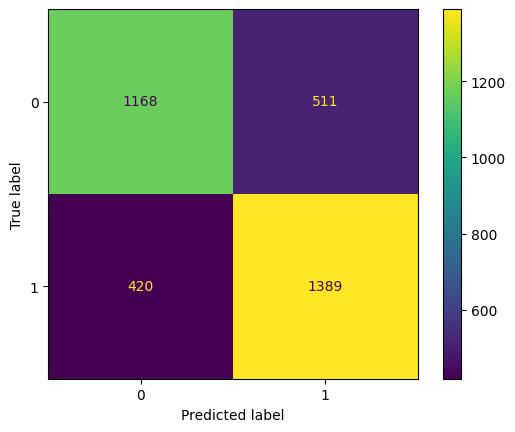

In [156]:
param_grid = [{'C':np.linspace(30000009000,30000009001,2),'gamma':np.linspace(1e-5,1e-4,2), 'kernel':['rbf'], 'degree': [1]}]
optimal_params = GridSearchCV(SVC(), param_grid, cv =2, scoring='f1',n_jobs=4, verbose = 2)
optimal_params.fit(X_train_scaled, Y_train)
print(optimal_params.best_params_)
clf_svm = SVC(degree = 1, kernel='rbf', gamma = optimal_params.best_params_['gamma'], C = optimal_params.best_params_['C'], verbose=True)
clf_svm.fit(X_train_scaled, Y_train)
disp=ConfusionMatrixDisplay(confusion_matrix(Y_test, clf_svm.predict(X_test_scaled)))
disp.plot() 
plt.show()

Good minimas: C = 30009000, gamma = 0.00010666666666666667

In [9]:
data1

,BOLl,BOLu,Squeeze,Bollinger Band Gap,Diff_bw_typ_and_ma,Typical_Price,RSI,Normalized Moving Average Slope,Moving Average,Signal_MACD_strength,Signal_Value,MACD_Value,Average,Open,High,Low,Close,Adj Close,Volume
0,0.000000,0.000000,0.0,0.000000,0.000000,0.128534,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.128348,0.128348,0.128906,0.128348,0.128348,0.099584,469033600
1,0.000000,0.000000,0.0,0.000000,0.000000,0.121838,0.000000,0.000000,0.000000,1,-0.000102,-0.000512,0.121931,0.122210,0.122210,0.121652,0.121652,0.094388,175884800
2,0.000000,0.000000,0.0,0.000000,0.000000,0.112909,0.000000,0.000000,0.000000,1,-0.000406,-0.001619,0.113002,0.113281,0.113281,0.112723,0.112723,0.087461,105728000
3,0.000000,0.000000,0.0,0.000000,0.000000,0.115699,0.000000,0.000000,0.000000,1,-0.000778,-0.002268,0.115513,0.115513,0.116071,0.115513,0.115513,0.089625,86441600
4,0.000000,0.000000,0.0,0.000000,0.000000,0.119048,0.000000,0.000000,0.000000,1,-0.001119,-0.002484,0.118862,0.118862,0.119420,0.118862,0.118862,0.092224,73449600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10598,130.320827,151.681674,0.0,21.360846,-9.694584,131.306666,25.972626,-0.026754,141.001250,1,-2.411097,-3.623720,131.389999,130.919998,132.419998,129.639999,131.860001,131.477127,63814900
10599,129.136234,151.468767,0.0,22.332533,-10.249166,130.053335,27.235043,-0.022233,140.302501,1,-2.701818,-3.864703,130.705002,131.380005,131.410004,128.720001,130.029999,129.652435,69007800
10600,127.611297,151.506205,0.0,23.894908,-11.912083,127.646667,27.743490,-0.023663,139.558751,1,-3.008818,-4.236816,127.855000,129.669998,131.029999,125.870003,126.040001,125.674019,85438400
10601,125.690632,151.835369,0.0,26.144737,-9.489668,129.273333,27.755230,-0.025316,138.763001,1,-3.287992,-4.404690,128.799999,127.989998,130.479996,127.730003,129.610001,129.233658,75703700


[*********************100%***********************]  1 of 1 completed


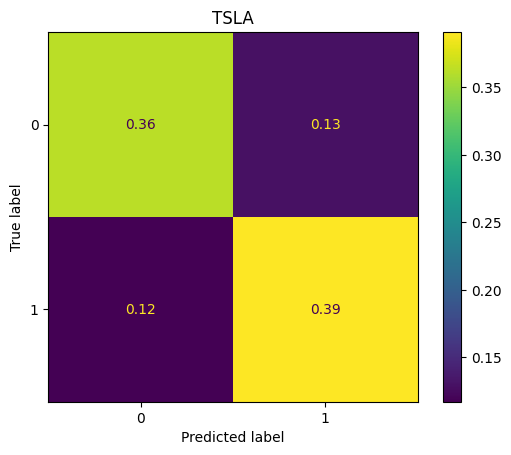

[*********************100%***********************]  1 of 1 completed


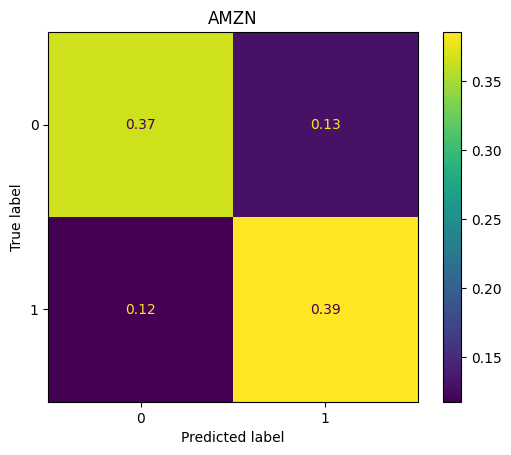

[*********************100%***********************]  1 of 1 completed


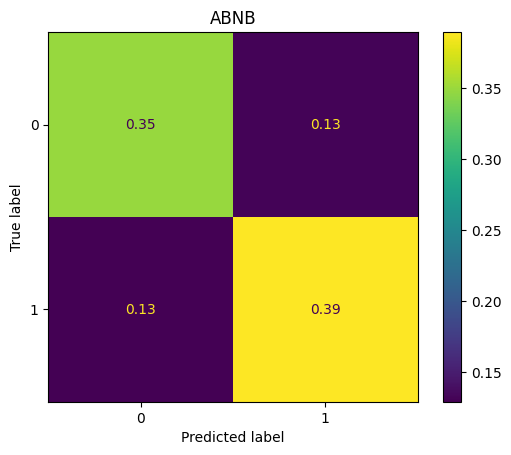

[*********************100%***********************]  1 of 1 completed


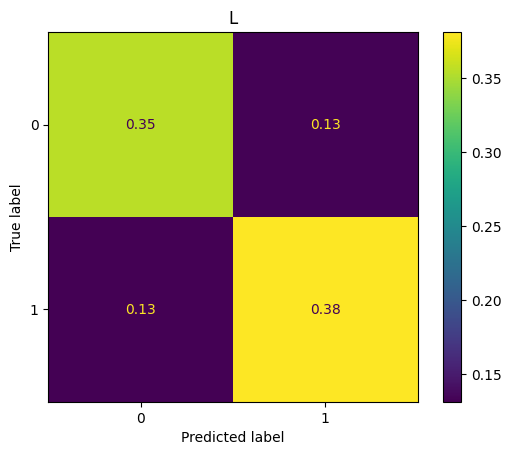

[*********************100%***********************]  1 of 1 completed


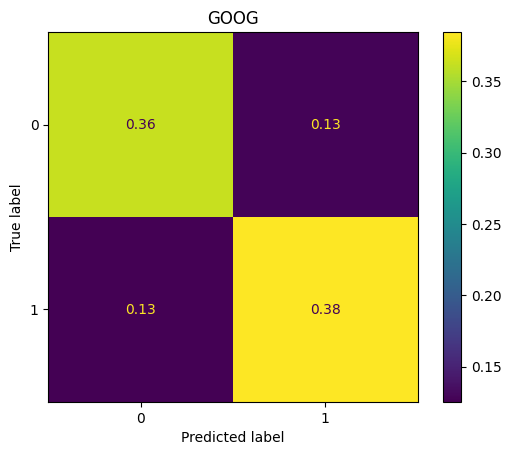

[*********************100%***********************]  1 of 1 completed


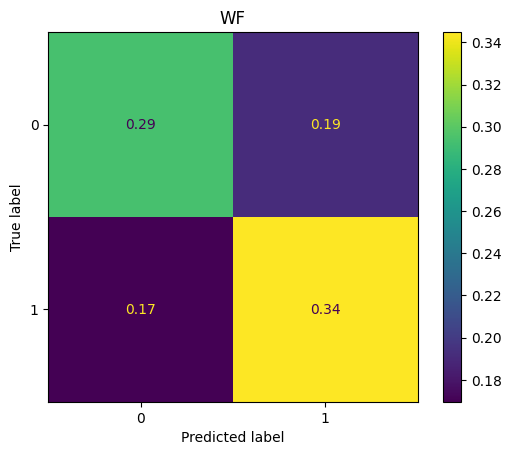

[*********************100%***********************]  1 of 1 completed


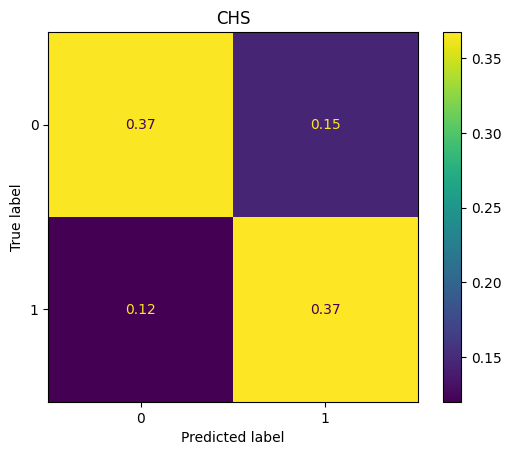

[*********************100%***********************]  1 of 1 completed


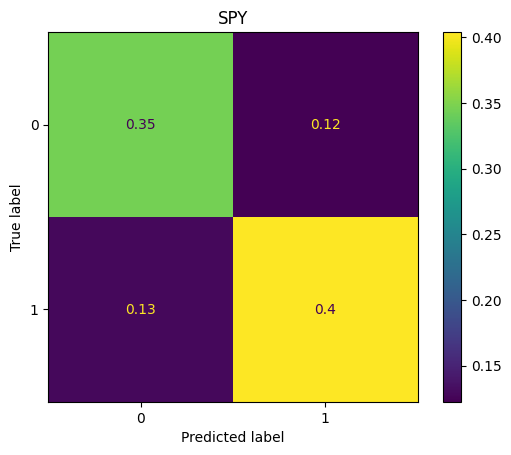

[*********************100%***********************]  1 of 1 completed


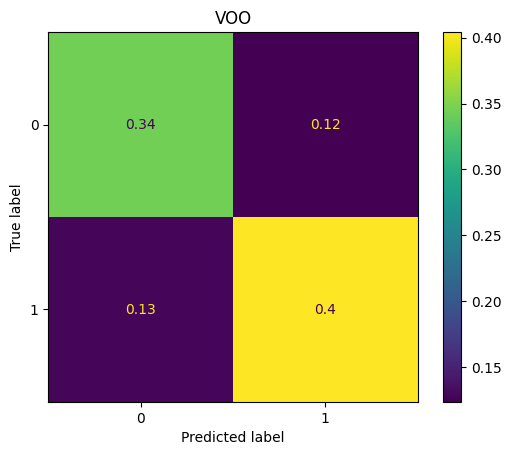

[*********************100%***********************]  1 of 1 completed


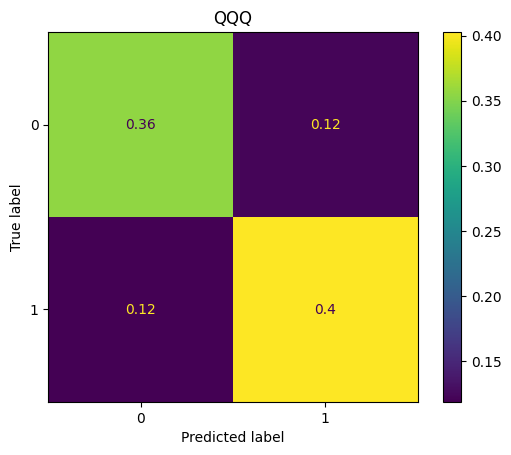

In [171]:
tickers = ['TSLA','AMZN','ABNB','L','GOOG','WF','CHS','SPY','VOO','QQQ']
for ticker_name in tickers:
    data2 = yf.download(ticker_name, start='2021-09-07', end = '2023-09-05',interval = '1h')
    data1 = pre_process(data2,Moving_window=20)
    percentchange = data1['Change'].to_numpy()
    data1.drop(['Change'], axis=1, inplace=True)
    percentchange = percentchange[1:]
    percentchange = np.append(percentchange,0)
    for i in range(len(percentchange)):
        if (percentchange[i]>0):
            percentchange[i] = 1
        else:
            percentchange[i] = 0
    data_encoded = pd.get_dummies(data1, columns=['Signal_MACD_strength'], dtype = 'float32')
    data_encoded['Volume'] = data_encoded['Volume']/100000 
    Y = percentchange
    data1.fillna(0,inplace=True)
    X_test_new,Y_test_new = data_encoded[:-1],Y[:-1]
    X_test_scaled_new = scale(X_test_new)
    disp=ConfusionMatrixDisplay(confusion_matrix(Y_test_new, clf_svm.predict(X_test_scaled_new),normalize = 'all'))
    disp.plot()
    plt.title(ticker_name) 
    plt.show()